In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("spam.csv")

data = df.copy() # make a copy of the data
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

#rename the label and text columns
data = data.rename(columns={"v1":"label", "v2":"text"})

#convert spam/ham labels into data alg can read
data['label'] = data['label'].map( {'spam': 1, 'ham': 0} )

In [ ]:
X = data['text'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

In [ ]:
# integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[38, 30, 8, 5, 273, 1989, 81, 116, 26, 11, 1656, 322, 10, 53, 18, 299, 30, 349, 1990], [799, 15, 2555, 1442, 1127, 192, 2556, 171, 12, 98, 1991, 44, 195, 1657, 2557, 1992, 2558, 21, 9, 4, 203, 1025, 225]]


In [ ]:
# pad documents to a max length of 8words
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
print(padded_train)

[[ 322   10   53 ...   30  349 1990]
 [1992 2558   21 ...  203 1025  225]
 [  83 1443    4 ...    2 3794 3795]
 ...
 [1477   30 2063 ...  239   30 2064]
 [ 763 1679 1161 ...    0    0    0]
 [   8  155   20 ...    8  290  175]]


In [ ]:
vocab_size = len(t.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 24)             190920    
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 500)               96500     
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train,
         y=y_train,
         epochs=50,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

Epoch 1/50
140/140 [==============================] - 4s 19ms/step - loss: 0.2280 - accuracy: 0.9123 - val_loss: 0.1013 - val_accuracy: 0.9785
Epoch 2/50
140/140 [==============================] - 3s 18ms/step - loss: 0.0584 - accuracy: 0.9816 - val_loss: 0.0781 - val_accuracy: 0.9821
Epoch 3/50
140/140 [==============================] - 2s 11ms/step - loss: 0.0239 - accuracy: 0.9928 - val_loss: 0.1025 - val_accuracy: 0.9794
Epoch 4/50
140/140 [==============================] - 1s 7ms/step - loss: 0.0074 - accuracy: 0.9989 - val_loss: 0.1106 - val_accuracy: 0.9794
Epoch 5/50
140/140 [==============================] - 1s 8ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.1323 - val_accuracy: 0.9776
Epoch 6/50
140/140 [==============================] - 1s 7ms/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.1578 - val_accuracy: 0.9722
Epoch 7/50
140/140 [==============================] - 1s 7ms/step - loss: 1.5946e-04 - accuracy: 1.0000 - val_loss: 0.1797 - val_accuracy: 0.9731

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

In [ ]:
preds = (model.predict(padded_test) > 0.5).astype("int32")

35/35 [==============================] - 0s 2ms/step


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.96      0.89      0.92       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy : 0.9802690582959641


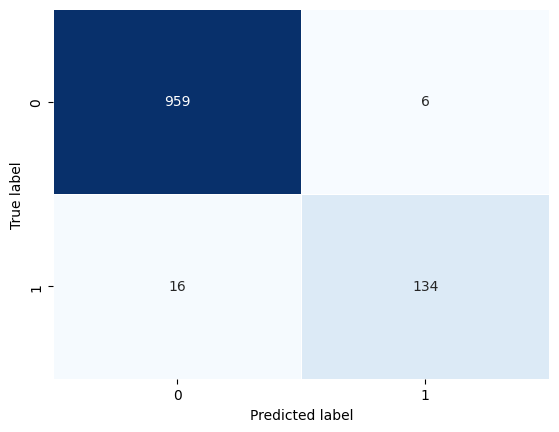

In [ ]:
c_report(y_test, preds)
plot_confusion_matrix(y_test, preds)